# MSFT Stock Price Prediction using HMM [closing-difference]

In [1]:
import numpy as np
import pandas as pd
import datetime
#from pandas_datareader import data 
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

In [2]:
securities = pd.read_csv('./data/HistoricalData_1731717279142.csv')
print((securities.head()).to_markdown(tablefmt="grid"))
print(securities.info(verbose=False))


securities['Date'] = pd.to_datetime(securities['Date']).map(pd.Timestamp.toordinal)

securities = securities.sort_values(by='Date').reset_index(drop=True)
securities['Prev_Close'] = securities['Close/Last'].shift(1)

for col in ['Close/Last', 'Open', 'High', 'Low', 'Prev_Close']:
    securities[col] = securities[col].str.replace('$', '').astype(float)

securities.dropna(inplace=True)

print((securities.head()).to_markdown(tablefmt="grid"))

securities.to_csv('./data/MSFT.csv', index=False)

securities.drop(['Open','High','Low','Prev_Close'],axis=1,inplace=True)
print((securities.head()).to_markdown(tablefmt="grid"))

securities = list(securities.itertuples(index=False, name=None))

+----+------------+--------------+----------+----------+----------+---------+
|    | Date       | Close/Last   |   Volume | Open     | High     | Low     |
+====+============+==============+==========+==========+==========+=========+
|  0 | 11/14/2024 | $426.89      | 30246880 | $425.00  | $428.17  | $420.00 |
+----+------------+--------------+----------+----------+----------+---------+
|  1 | 11/13/2024 | $425.20      | 21502190 | $421.64  | $429.325 | $418.21 |
+----+------------+--------------+----------+----------+----------+---------+
|  2 | 11/12/2024 | $423.03      | 19401200 | $418.25  | $424.44  | $417.20 |
+----+------------+--------------+----------+----------+----------+---------+
|  3 | 11/11/2024 | $418.01      | 24503320 | $422.515 | $424.81  | $416.00 |
+----+------------+--------------+----------+----------+----------+---------+
|  4 | 11/08/2024 | $422.54      | 16891410 | $425.32  | $426.50  | $421.78 |
+----+------------+--------------+----------+----------+--------

In [3]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(securities, test_size=.2, shuffle=False)

In [4]:
securities = train_data

dates = np.array([x[0] for x in securities], dtype=int)
print(dates)
close_price = np.array([x[1] for x in securities])
print(close_price)
volume = np.array([x[2] for x in securities])[1:]
print(volume)

[735555 735556 735557 ... 738469 738470 738473]
[ 48.74  48.22  48.7  ... 242.98 247.11 241.55]
[26166200 21486310 42867970 ... 46268020 34620250 31123340]


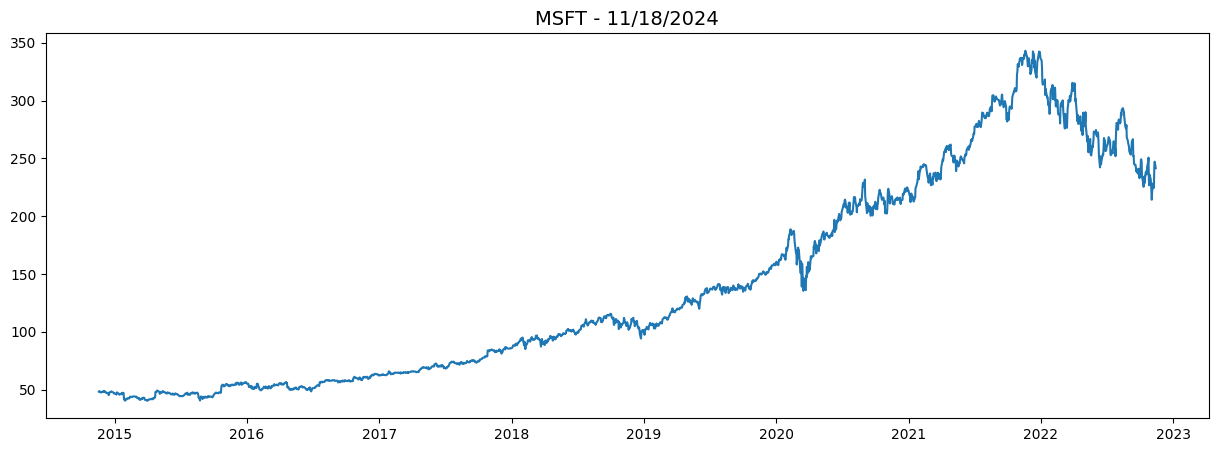

In [5]:
diff = np.diff(close_price)
dates = dates[1:]
close_price = close_price[1:]
volume = volume[:]

assert len(diff) == len(volume) == len(close_price) == len(dates), "Array lengths do not match"

start_date = datetime.date(2014, 11, 17)
end_date = datetime.date.today()
actual_date = [datetime.date.fromordinal(x) for x in dates]

X = np.column_stack([diff, volume])

plt.figure(figsize=(15, 5), dpi=100) 
plt.title("MSFT" + " - " + end_date.strftime("%m/%d/%Y"), fontsize = 14)
plt.gca().xaxis.set_major_locator(YearLocator())
plt.plot_date(actual_date,close_price,"-")
plt.show()

In [6]:

data = list(zip(actual_date[1:], close_price, diff))
data =  pd.DataFrame(data, columns=['Date','Closing Price', 'Difference'])
print((data.head()).to_markdown(tablefmt='grid'))

+----+------------+-----------------+--------------+
|    | Date       |   Closing Price |   Difference |
+====+============+=================+==============+
|  0 | 2014-11-20 |           48.22 |        -0.52 |
+----+------------+-----------------+--------------+
|  1 | 2014-11-21 |           48.7  |         0.48 |
+----+------------+-----------------+--------------+
|  2 | 2014-11-24 |           47.98 |        -0.72 |
+----+------------+-----------------+--------------+
|  3 | 2014-11-25 |           47.59 |        -0.39 |
+----+------------+-----------------+--------------+
|  4 | 2014-11-26 |           47.47 |        -0.12 |
+----+------------+-----------------+--------------+


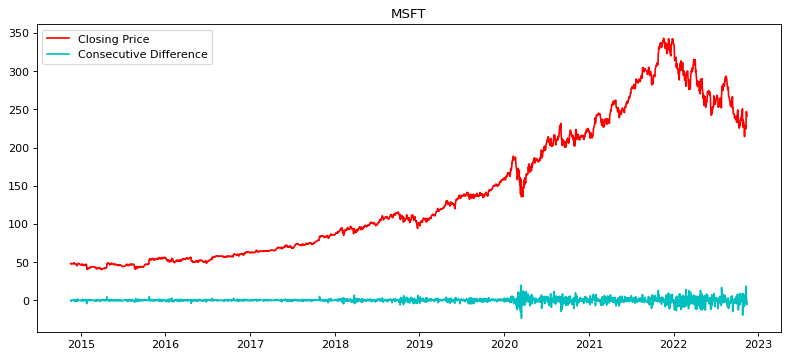

In [7]:
plt.figure(figsize=(12, 5), dpi=80 )
plt.title('MSFT', fontsize = 12)
plt.plot(actual_date,close_price,'r-')
plt.plot(actual_date,diff, 'c-')
plt.legend(['Closing Price','Consecutive Difference'])
plt.show()

hmm.GMMHMM(n_components=1, n_mix=1, min_covar=0.001, startprob_prior=1.0, transmat_prior=1.0, weights_prior=1.0, means_prior=0.0, means_weight=0.0, covars_prior=None, covars_weight=None, algorithm='viterbi', covariance_type='diag', random_state=None, n_iter=10, tol=0.01, verbose=False, params='stmcw', init_params='stmcw')

## HMM Hyperparameter tuning

In [8]:
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import ParameterGrid
import numpy as np

param_grid = {
    "n_components": [2, 3, 4, 5],
    "covariance_type": ["diag", "full"],
    "tol": [1e-3, 1e-4],
    "n_iter": [1000, 5000]
}

grid = ParameterGrid(param_grid)

best_model = None
best_score = -np.inf
best_params = None

for params in grid:
    model = GaussianHMM(
        n_components=params["n_components"],
        covariance_type=params["covariance_type"],
        tol=params["tol"],
        n_iter=params["n_iter"]
    )
    model.fit(X)
    
    score = model.score(X)
    if score > best_score:
        best_model = model
        best_score = score
        best_params = params

print("Best Parameters:", best_params)
print("Best Log-Likelihood:", best_score)

Best Parameters: {'covariance_type': 'full', 'n_components': 5, 'n_iter': 1000, 'tol': 0.001}
Best Log-Likelihood: -38727.524752348254


## HMMLearn Model and Visualization

In [9]:
model = GaussianHMM(n_components=4,  n_iter=10000, tol=0.001)
# model = GaussianHMM(covariance_type='full', n_components=5,  n_iter=1000, tol=0.001)
model.fit(X)

GaussianHMM(n_components=4, n_iter=10000, tol=0.001)

In [10]:
model.monitor_

ConvergenceMonitor(
    history=[-41926.601563709206, -40025.12942126106, -39631.641718989784, -39458.441317480596, -39368.77801506717, -39302.224041042915, -39258.12128504059, -39230.288998856005, -39208.74340244088, -39190.81936990379, -39175.58730403905, -39162.93925418772, -39153.32369621473, -39147.301589531264, -39143.782150683546, -39141.53708352788, -39139.78520035296, -39138.02040944702, -39135.82770796534, -39132.77509429238, -39128.32996913766, -39121.759175569525, -39112.19504228447, -39098.73283490528, -39081.670092483226, -39064.974863610434, -39050.26375064664, -39037.16099060462, -39025.827766606126, -39016.62019361136, -39009.625485353645, -39004.218925036665, -38999.60993773543, -38995.15147841816, -38989.918686359684, -38982.001616587215, -38974.43860627146, -38969.337732408996, -38966.566103370096, -38965.02587989476, -38964.130022460784, -38963.58377595751, -38963.23013515175, -38962.984922353935, -38962.803167286555, -38962.66060761406, -38962.543854983924, -38962

In [11]:
import pickle

In [12]:
securities = test_data

dates = np.array([x[0] for x in securities], dtype=int)
close_price = np.array([x[1] for x in securities])
volume = np.array([x[2] for x in securities])[1:]

In [13]:
diff = np.diff(close_price)
dates = dates[1:]
close_price = close_price[1:]

X = np.column_stack([diff, volume])
hidden_states = model.predict(X)

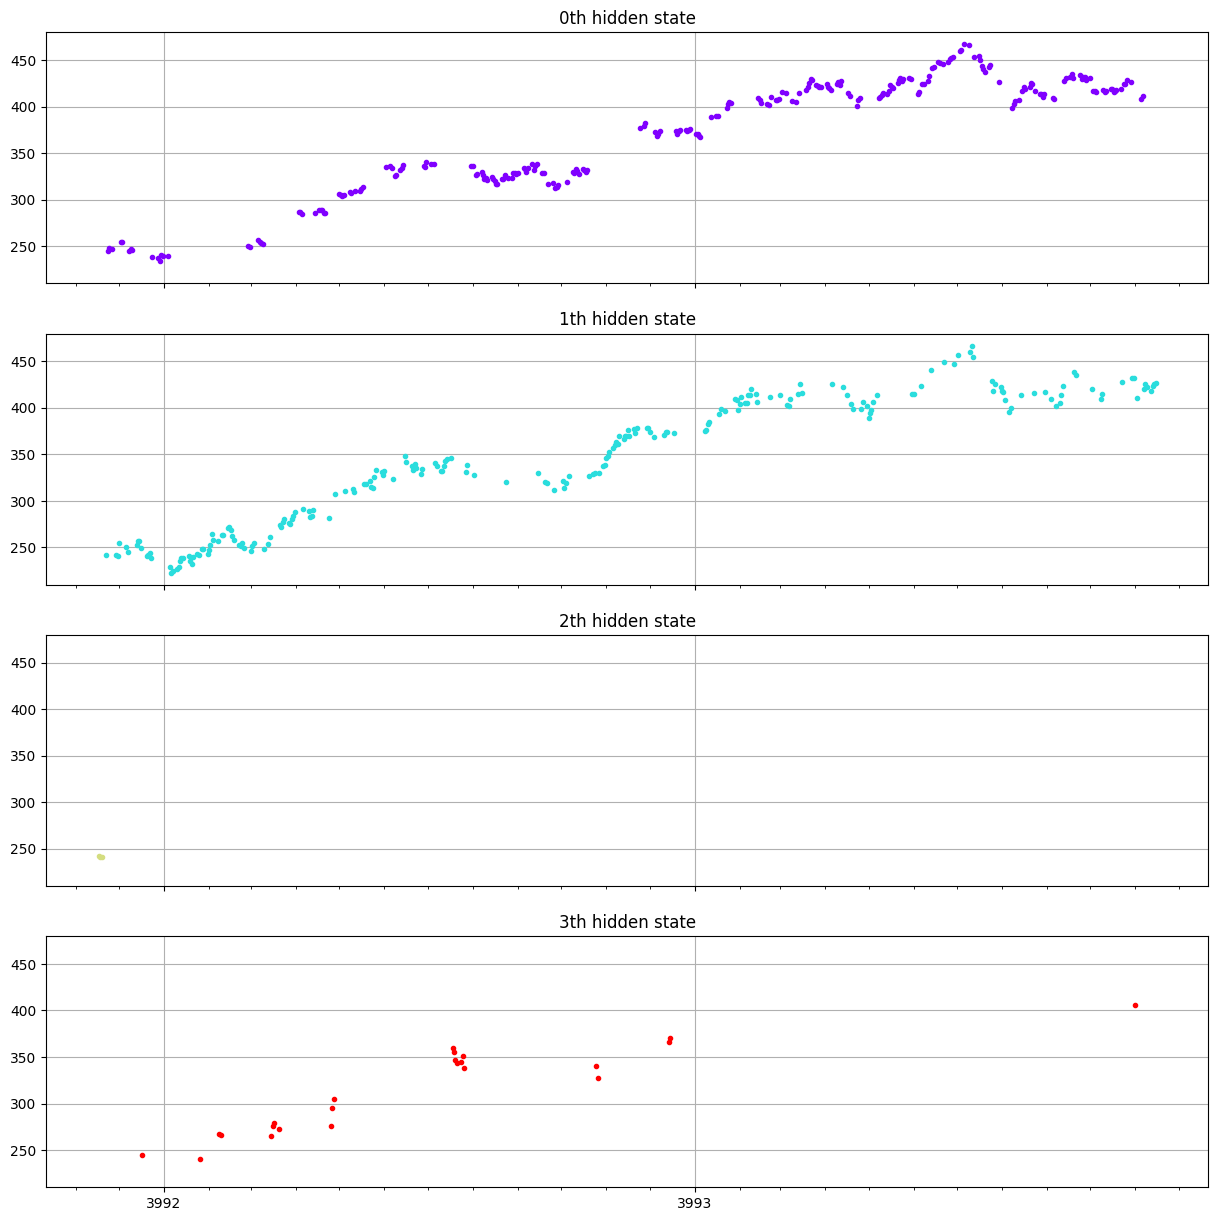

In [14]:

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(15,15))
colours = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, colour) in enumerate(zip(axs, colours)):
    mask = hidden_states == i
    ax.plot_date(dates[mask], close_price[mask], ".", c=colour)
    ax.set_title("{0}th hidden state".format(i))
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    ax.grid(True)
plt.show()

In [19]:
expected_returns_and_volumes = np.dot(model.transmat_, model.means_)
returns_and_volume = list(zip(*expected_returns_and_volumes))
expected_returns = returns_and_volume[0]
expected_volumes = returns_and_volume[1]
params = pd.concat([pd.Series(expected_returns), pd.Series(expected_volumes)], axis=1)
params.columns= ['Returns', 'Volume']
params.head()

,Returns,Volume
0,0.280855,2.291916e+07
1,0.097409,3.229678e+07
2,0.062682,2.761597e+07
3,-0.239204,5.049655e+07


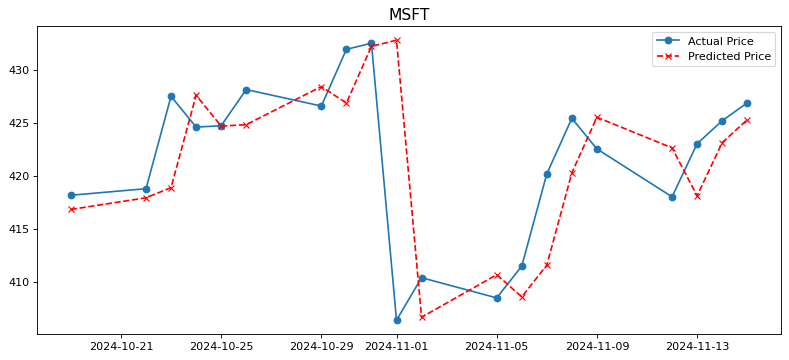

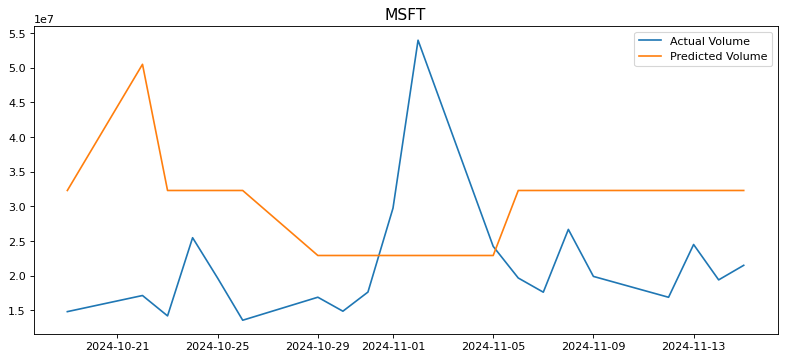

In [20]:
lastN = 20
predicted_prices = []
predicted_dates = []
predicted_volumes = []
actual_volumes = []

for idx in range(lastN):
    state = hidden_states[lastN+idx]
    current_price = securities[-lastN-1+idx][1]
    volume = securities[-lastN-1+idx][2]
    actual_volumes.append(volume)
    current_date = datetime.date.fromordinal(dates[-lastN+idx])
    predicted_date = current_date + datetime.timedelta(days=1)
    predicted_dates.append(predicted_date)
    predicted_prices.append(current_price + expected_returns[state])
    predicted_volumes.append(np.round(expected_volumes[state]))    

#Returns
plt.figure(figsize=(12, 5), dpi=80) 
plt.title('MSFT', fontsize = 14)
plt.plot(predicted_dates,close_price[-lastN:], 'o-')
plt.plot(predicted_dates,predicted_prices,'rx--')
plt.legend(['Actual Price','Predicted Price'])
plt.show()

#Volumes
plt.figure(figsize=(12, 5), dpi=80) 
plt.title('MSFT', fontsize = 14)
plt.plot(predicted_dates,actual_volumes)
plt.plot(predicted_dates,predicted_volumes)
plt.legend(['Actual Volume','Predicted Volume'])
plt.show()

In [22]:
actual_date = [datetime.date.fromordinal(x) for x in dates[-lastN:]]
data = list(zip(actual_date, close_price[-lastN:], predicted_prices))
data =  pd.DataFrame(data, columns=['Date','Actual Price', 'Predicted Price'])
data.head()

,Date,Actual Price,Predicted Price
0,2024-10-18,418.16,416.817409
1,2024-10-21,418.78,417.920796
2,2024-10-22,427.51,418.877409
3,2024-10-23,424.60,427.607409
4,2024-10-24,424.73,424.697409


In [23]:
abs_diff = np.abs(data['Actual Price'] - data['Predicted Price'])

MAE = np.mean(abs_diff)
MSE = np.mean(abs_diff ** 2)
RMSE = np.sqrt(MSE)
MAPE = np.mean(abs_diff*100/data['Actual Price'])

metrices = [MAE, RMSE, MAPE]

pd.set_option("display.precision", 4)
metrices = pd.DataFrame(metrices, index =['MAE', 'MSE', 'MAPE'], columns =['Score'])
metrices

,Score
MAE,4.4844
MSE,7.1278
MAPE,1.0740
